In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys

SCRIPT_DIR = Path('/home/alina.smolina/DL-pipeline/src')
sys.path.append(str(SCRIPT_DIR))

In [3]:
import torch
import time
import glob

In [4]:
torch.set_float32_matmul_precision('medium')

In [5]:
import wandb

In [6]:
import pytorch_lightning as pl

🪄: shape of the resulting tensor is (10, 8000, 2379)


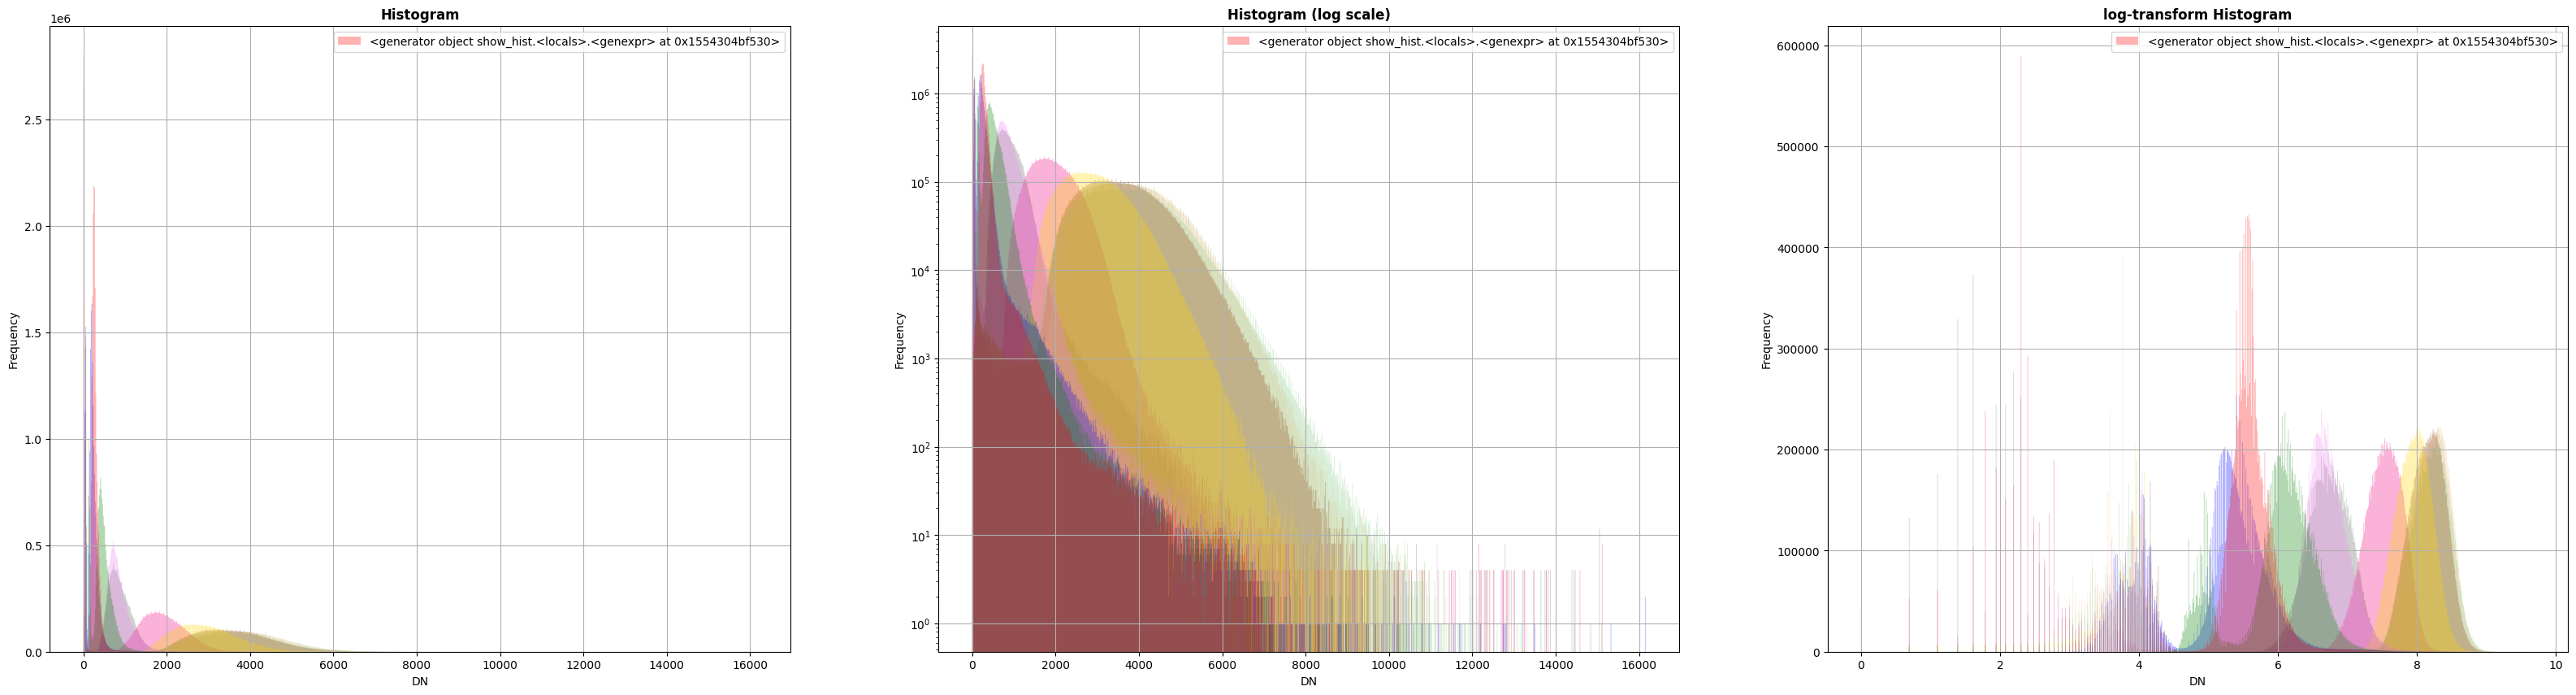

🪄: shape of the resulting tensor is (10, 2461, 2379)


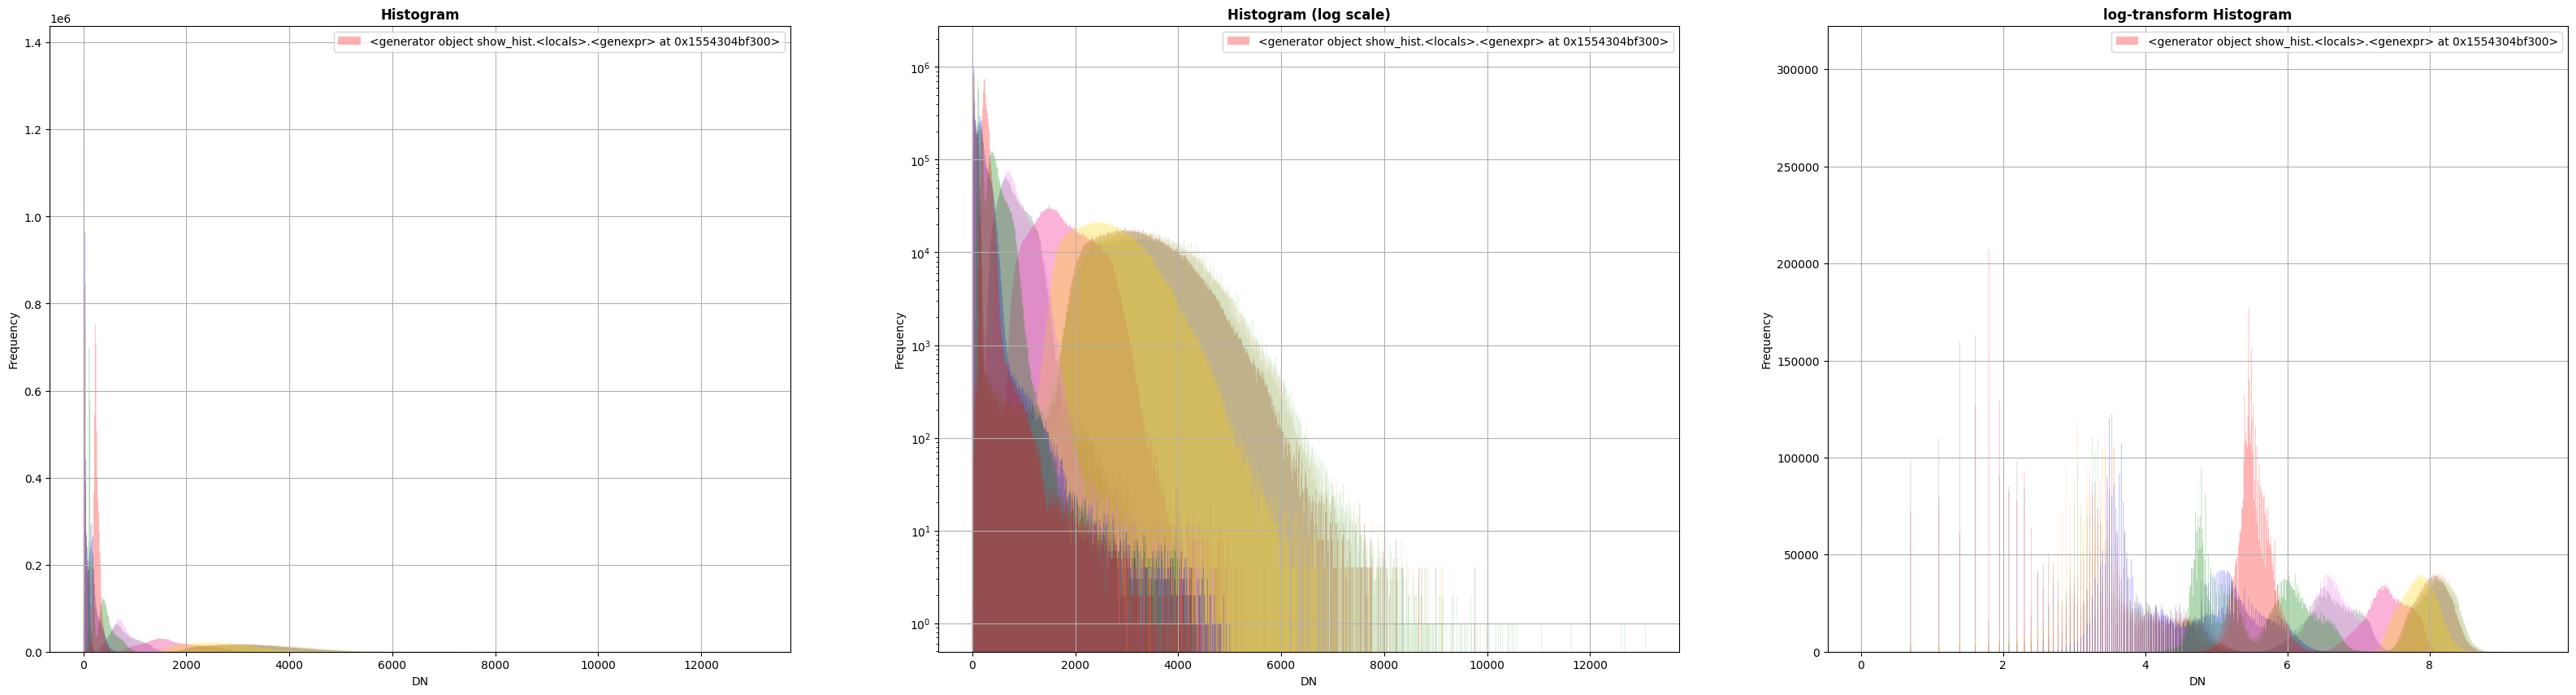

🪄: shape of the resulting tensor is (1, 8000, 2379)
🪄: shape of the resulting tensor is (1, 2461, 2379)
🪄: shape of the resulting tensor is (1, 8000, 2379)
🪄: shape of the resulting tensor is (1, 2461, 2379)


In [31]:
import matplotlib.pyplot as plt
from rasterio.windows import Window
import pandas as pd
import rasterio
import numpy as np
from rasterio.plot import show_hist
from pprint import pprint

### Korsak
# Get table with types and ages
# Target map shape is: (h, w) = (12775, 6965)

### Nevelsk
# Get table with types and ages
# Target map shape is: (h, w) = (10461, 2379)
#### -------------------------------> [x]
####|          ____________
####|         |            |
####|         |   TRAIN    |
####|         |            |
####|   (0, a).____________.(w, a)
####|         |            |
####|         |    TEST    |
####|         |            |
####|   (h, a).____________.(w, h)
####|
####|
####\/ [y]


h, w = 10461, 2379
a = 8000
y0, x0 = 0, 0
train_window = Window.from_slices((y0, y0 + a), (x0, x0 + w))
y0, x0 = a, 0
test_window = Window.from_slices((y0, h), (x0, x0 + w))

images_dir = './../data/images/nevelsk/20180806'
channels_list = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']

target_dir = './../data/images/nevelsk/rasterized'
target = '1layer_prevail_group_2groups'


def get_data(channels_list, path, window=None, get_stat=False):
    channels = []
    for ch in channels_list:
        with rasterio.open(f'{path}/{ch}.tif') as src:
            if window is None:
                channels += [src.read(1)]
            else:
                channels += [src.read(1, window=window)]

    multispectral_img = np.stack(channels)
    print(f'🪄: shape of the resulting tensor is {multispectral_img.shape}')
    
    band_stats = {}
    
    if get_stat:
        
        flattened_multispectral_img = multispectral_img.reshape(multispectral_img.shape[0], -1)
        maximums = np.max(flattened_multispectral_img, axis=-1)
        minimums = np.min(flattened_multispectral_img, axis=-1)
        means = np.mean(flattened_multispectral_img, axis=-1)
        stds = np.std(flattened_multispectral_img, axis=-1)
        percentiles_99 = np.percentile(flattened_multispectral_img, q=99, axis=-1)
        percentiles_1 = np.percentile(flattened_multispectral_img, q=1, axis=-1)
        for i, ch in enumerate(channels_list):
            band_stats[ch] = {'min': minimums[i], 
                              'max': maximums[i], 
                              'mean': means[i], 
                              'std': stds[i],
                              'percentile_99': percentiles_99[i],
                              'percentile_1': percentiles_1[i],
                             }
        
        fig, axes = plt.subplots(1, 3, figsize=(40, 10))
        show_hist(multispectral_img, bins=1000, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram", ax=axes[0])
        show_hist(multispectral_img, bins=1000, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram (log scale)", log=True, ax=axes[1])
        show_hist(np.log(multispectral_img), bins=1000, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="log-transform Histogram", ax=axes[2])
        plt.show()

    return multispectral_img, band_stats


X_train, band_stats_train = get_data(channels_list, images_dir, window=train_window, get_stat=True)
X_test, _ = get_data(channels_list, images_dir, window=test_window, get_stat=True)

SCL_train, _ = get_data(['SCL'], images_dir, window=train_window)
SCL_test, _ = get_data(['SCL'], images_dir, window=test_window)

Y_train, _ = get_data([target], target_dir, window=train_window) 
Y_test, _ = get_data([target], target_dir, window=test_window)

# so that class indices are in the range [0,C) (for torch.nn.CrossEntropy)
Y_train = Y_train - 1
Y_test = Y_test - 1

In [47]:
H_img_size = 246
W_img_size = 237
C_num_channels = 3
x = torch.arange(H_img_size*W_img_size).view(H_img_size, W_img_size)
x = x.expand(C_num_channels, H_img_size, W_img_size)
x = x.float()

In [48]:
from torch.nn import functional as F

kernel_h, kernel_w = 32, 32
stride_h, stride_w = 16, 16

print(f'1. {x.shape}')
# Pad to multiples of 32
x = F.pad(x, (x.size(2)%kernel_w // 2, x.size(2)%kernel_w // 2,
              x.size(1)%kernel_h // 2, x.size(1)%kernel_h // 2,),
          mode='reflect'
         )
print(x)
print(f'2. {x.shape} - pad')

patches = x.unfold(1, kernel_h, stride_h).unfold(2, kernel_w, stride_w)
unfold_shape = patches.size()
print(unfold_shape, 'unfold_shape')
patches = patches.contiguous().view(-1, kernel_h, kernel_w)
print(patches.shape, 'patches.shape')

# Reshape back
patches_orig = patches.view(unfold_shape)
output_h = unfold_shape[1] * unfold_shape[3]
output_w = unfold_shape[2] * unfold_shape[4]
patches_orig = patches_orig.permute(0, 1, 3, 2, 4).contiguous()
patches_orig = patches_orig.view(-1, output_h, output_w)

print(output_h, output_w)
# Check for equality
print(patches_orig.shape)
print(x[:, :output_h, :output_w].shape)
print((patches_orig == x[:, :output_h, :output_w]).all())

1. torch.Size([3, 246, 237])
tensor([[[ 2613.,  2612.,  2611.,  ...,  2839.,  2838.,  2837.],
         [ 2376.,  2375.,  2374.,  ...,  2602.,  2601.,  2600.],
         [ 2139.,  2138.,  2137.,  ...,  2365.,  2364.,  2363.],
         ...,
         [55938., 55937., 55936.,  ..., 56164., 56163., 56162.],
         [55701., 55700., 55699.,  ..., 55927., 55926., 55925.],
         [55464., 55463., 55462.,  ..., 55690., 55689., 55688.]],

        [[ 2613.,  2612.,  2611.,  ...,  2839.,  2838.,  2837.],
         [ 2376.,  2375.,  2374.,  ...,  2602.,  2601.,  2600.],
         [ 2139.,  2138.,  2137.,  ...,  2365.,  2364.,  2363.],
         ...,
         [55938., 55937., 55936.,  ..., 56164., 56163., 56162.],
         [55701., 55700., 55699.,  ..., 55927., 55926., 55925.],
         [55464., 55463., 55462.,  ..., 55690., 55689., 55688.]],

        [[ 2613.,  2612.,  2611.,  ...,  2839.,  2838.,  2837.],
         [ 2376.,  2375.,  2374.,  ...,  2602.,  2601.,  2600.],
         [ 2139.,  2138.,  21

RuntimeError: The size of tensor a (448) must match the size of tensor b (249) at non-singleton dimension 2

In [29]:
64+16+16+16


112

In [8]:
# pprint(band_stats_train)

In [9]:
from datamodule import GeoModule 
import albumentations as A
import albumentations.pytorch as AP

# transforms = A.Compose([
#     A.RandomCrop(256, 256),
#     A.Flip(p=0.3),
#     A.ShiftScaleRotate(
#         shift_limit=(-0.0625, 0.0625), 
#         scale_limit=0, #no scale
#         rotate_limit=(-90, 90), 
#         p=0.5
#     ),
#     AP.ToTensorV2(transpose_mask=True),
#     ],
#     additional_targets={'mask0':'mask'}
# )


data_20180806 = GeoModule(
    X_train, 
    Y_train, 
    X_test, 
    Y_test,
    SCL_train,
    SCL_test,
    transform=None,#transforms,
    batch_size=64,
    patch_size=128, #512,
    stride =128, # 512,
    norm_strategy='min_max',
)

In [10]:
from module import SegModule
from pytorch_lightning.loggers import WandbLogger
WANDB__SERVICE_WAIT=300
wandb_logger = WandbLogger(project='dl-pipeline', log_model=True)
print(f'🤖: Look at {wandb.run.url}')

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=f'../weights/group-2classes/{wandb.run.name}/',
    filename='{epoch}-{val_loss:.2f}', 
    monitor='val/mean_acc',
    mode='max',
    save_top_k=1
)

                   
trainer = pl.Trainer(
    max_epochs=20, 
    benchmark=True, 
    check_val_every_n_epoch=10, 
    logger=wandb_logger, 
    callbacks=[
        checkpoint_callback
              ],
)

model = SegModule(
    optimizer='Adam', 
    scheduler='StepLR',
    step_size=150,
    gamma=0.3,
    lr=3e-3,
)

trainer.fit(model, data_20180806)

wandb: Currently logged in as: nali. Use `wandb login --relogin` to force relogin


/trinity/home/alina.smolina/.conda/envs/torch/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /trinity/home/alina.smolina/.conda/envs/torch/lib/py ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


🤖: Look at https://wandb.ai/nali/dl-pipeline/runs/v4xg6qqy
🤖: Setup data...
🤖: percentile_99 = [ 734. 1166.  935. 1766. 4898. 5892. 6300. 6206. 3207. 1801.]
🤖: percentile_1 = [159. 106.  34.  29.  16.  23.  14.   7.   3.   1.]
🤖: Dataset initialized:
🤖: ><><><><><><><><><> Total #patches: 1116 [62 x 18]
🤖: ><><><><><><><><><> 64px are left in vertical direction
🤖: ><><><><><><><><><> 75px are left in horizontal direction
🤖: ><><><><><><><><><> (1116, 128, 128, 1) | #patches x patch_size x patch_size x 1
🤖: ><><><><><><><><><> max_percentage_of_nodata_pixels = 0.6
🤖: ><><><><><><><><><> 520 patches were skipped
🤖: ><><><><><><><><><> 596 are remaining


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name             | Type                       | Params
-----------------------------------------------------------------
0  | net              | UNet                       | 16.5 M
1  | loss_fn          | CrossEntropyLoss_notmasked | 0     
2  | train_precision  | ClasswiseWrapper           | 0     
3  | train_recall     | ClasswiseWrapper           | 0     
4  | train_f1score    | ClasswiseWrapper           | 0     
5  | train_mean_acc   | MulticlassAccuracy         | 0     
6  | val_conf_matrix  | MulticlassConfusionMatrix  | 0     
7  | val_precision    | ClasswiseWrapper           | 0     
8  | val_recall       | ClasswiseWrapper           | 0     
9  | val_f1score      | ClasswiseWrapper           | 0     
10 | val_mean_acc     | MulticlassAccuracy         | 0     
11 | test_conf_matrix | MulticlassConfusionMatrix  | 0     
12 | test_precision   | ClasswiseWrapper           | 0     
13 | test_recall      | ClasswiseWrapper           

Sanity Checking: 0it [00:00, ?it/s]

🤖: #iterations in val dataloader: 2
🤖: #iterations in train dataloader: 8


/trinity/home/alina.smolina/.conda/envs/torch/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
